# Clustering the Beaded Helix With Non-Uniform Frame Weights

## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import MDAnalysis as md
from shapeGMMTorch import torch_sgmm
import torch
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Read trajectory

In [2]:
prmtopFileName = "../helix_template.pdb"
trajFileName = "../run_files/helix_folding_eps6.0.dcd"
coord = md.Universe(prmtopFileName,trajFileName)
print("Number of atoms in trajectory:", coord.atoms.n_atoms)
print("Number of frames in trajectory:", coord.trajectory.n_frames)
# make atom selection
atomSel = coord.select_atoms('all')
print("Number of atoms in selection:", atomSel.n_atoms)
# create traj data of selection
traj_data = np.empty((coord.trajectory.n_frames,atomSel.n_atoms,3),dtype=float)
#loop traj
for ts in coord.trajectory:
    traj_data[ts.frame,:] = atomSel.positions

Number of atoms in trajectory: 12
Number of frames in trajectory: 100001
Number of atoms in selection: 12


## Fit $\epsilon=30$ frame weights to 2 clusters

In [4]:
# scripts contains a built-in CV routine
from shapeGMMTorch import scripts
frame_weights = np.loadtxt("weights_eps30.dat")
sgmm_eps30 = scripts.sgmm_fit_with_attempts(traj_data, 2, 10, frame_weights=frame_weights,device=torch.device("cpu"),dtype=torch.float64)

Number of training frames: 100001
Number of clusters: 2
Number of attempts: 10
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1              58.707         356.370
       2              58.710          97.413
       3              58.708         125.661
       4              58.707         399.336
       5              58.708         126.212
       6              58.710          97.651
       7              58.710          97.855
       8              54.065         406.780
       9              58.710          97.763
      10              58.707         150.833


In [5]:
print(sgmm_eps30.weights)

[0.50975192 0.49024808]


In [6]:
print(np.linalg.norm(sgmm_eps30.precisions[0]-sgmm_eps30.precisions[1]))

445.84597020308155


In [7]:
# save pickled object
import pickle
file_obj = open("beaded_helix_sgmm2_eps30_frame_weights.pickle","wb")
pickle.dump(sgmm_eps30,file_obj)
file_obj.close()

## Fit $\epsilon=18$ frame weights to 2 clusters

In [8]:
# scripts contains a built-in CV routine
from shapeGMMTorch import scripts
frame_weights = np.loadtxt("weights_eps18.dat")
sgmm_eps18 = scripts.sgmm_fit_with_attempts(traj_data, 2, 10, frame_weights=frame_weights,device=torch.device("cpu"),dtype=torch.float64)

Number of training frames: 100001
Number of clusters: 2
Number of attempts: 10
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1              57.021          96.175
       2              57.022         143.533
       3              57.025          88.360
       4              57.017         343.778
       5              57.025          88.496
       6              52.442         197.006
       7              57.025          89.861
       8              57.021          97.096
       9              57.021         317.597
      10              57.021          96.267


In [9]:
print(sgmm_eps18.weights)

[0.50351453 0.49648547]


In [10]:
print(np.linalg.norm(sgmm_eps18.precisions[0]-sgmm_eps18.precisions[1]))

138.36926726014272


In [11]:
# save pickled object
import pickle
file_obj = open("beaded_helix_sgmm2_eps18_frame_weights.pickle","wb")
pickle.dump(sgmm_eps18,file_obj)
file_obj.close()

## Fit $\epsilon=8$ frame weights to 2 clusters

In [25]:
# scripts contains a built-in CV routine
from shapeGMMTorch import scripts
frame_weights = np.loadtxt("eps8_frame_weights.dat")
sgmm_eps8 = scripts.sgmm_fit_with_attempts(traj_data, 2, 10, frame_weights=frame_weights,device=torch.device("cpu"),dtype=torch.float64)

Number of training frames: 100001
Number of clusters: 2
Number of attempts: 10
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1              46.372         870.485
       2              46.326         941.019
       3              50.300          70.102
       4              50.297          66.771
       5              50.301          44.575
       6              50.299          76.494
       7              50.301          45.951
       8              50.299          72.865
       9              50.301          45.672
      10              50.297          68.315


In [26]:
print(sgmm_eps8.weights)

[0.50063989 0.49936011]


In [27]:
print(np.linalg.norm(sgmm_eps8.precisions[0]-sgmm_eps8.precisions[1]))

18.814628047724646


In [28]:
# save pickled object
import pickle
file_obj = open("beaded_helix_sgmm2_eps8_frame_weights.pickle","wb")
pickle.dump(sgmm_eps8,file_obj)
file_obj.close()

## Perform Cross Validation with frame weights for $\epsilon=18$

In [3]:
from shapeGMMTorch import scripts
cluster_array = np.arange(1,7).astype(int)
dtype = torch.float64

In [16]:
# load the weights
frame_weights = np.loadtxt("weights_eps18.dat")
print(np.sum(frame_weights))

0.9999999999999999


In [18]:
# CV scan with non-uniform weights
eps18_train, eps18_cv = scripts.cross_validate_cluster_scan(traj_data, 90000, frame_weights = frame_weights, covar_type="kronecker", cluster_array = cluster_array, n_training_sets=3, n_attempts = 10, dtype=dtype, device=torch.device("cpu"))

Number of frames to train each model: 90000
Number of frames to predict each model: 10001
Number of training sets: 3
Number of clusters: 6
Number of attempts per set/cluster: 10
   Training Set      N Clusters         Attempt  Log Like per Frame    CPU Time (s)
------------------------------------------------------------------------------------
              1               1               1              51.397         873.844
              1               2               1              52.767        1632.418
              1               2               2              57.076          75.946
              1               2               3              57.072         195.718
              1               2               4              57.070          98.294
              1               2               5              57.068         145.270
              1               2               6              57.076          75.790
              1               2               7              57.0

              2               6               3              58.862         461.090
              2               6               4              59.983         809.333
              2               6               5              59.643         505.277
              2               6               6              60.140         943.540
              2               6               7              59.670        1146.780
              2               6               8              59.687         481.802
              2               6               9              59.675         702.654
              2               6              10              59.804         520.697
              3               1               1              51.356         826.456
              3               2               1              57.018          75.554
              3               2               2              57.018          74.018
              3               2               3              52.393         

In [19]:
np.savetxt("eps18_frame_weights_ll_train_90k.dat", eps18_train)
np.savetxt("eps18_frame_weights_ll_cv_10k.dat", eps18_cv)

### Load log likelihood data for quick use

In [ ]:
# save data (optional - don't have to do this)
#np.savetxt("uniform_frame_weights_ll_train.dat", train)
#np.savetxt("uniform_frame_weights_ll_cv.dat", cv)
#np.savetxt("enm_frame_weights_ll_train.dat", enm_train)
#np.savetxt("enm_frame_weights_ll_cv.dat", enm_cv)
#np.savetxt("random_frame_weights_ll_train.dat", random_train)
#np.savetxt("random_frame_weights_ll_cv.dat", random_cv)

In [3]:
# load data
# NOTE - only do this if you want to overwrite active arrays
train = np.loadtxt("../uniform_frame_weights_ll_train_90k.dat")
cv = np.loadtxt("../uniform_frame_weights_ll_cv_10k.dat")
eps18_train = np.loadtxt("eps18_frame_weights_ll_train_90k.dat")
eps18_cv = np.loadtxt("eps18_frame_weights_ll_cv_10k.dat")

## Make Log Likelihood vs number of Cluster Plots

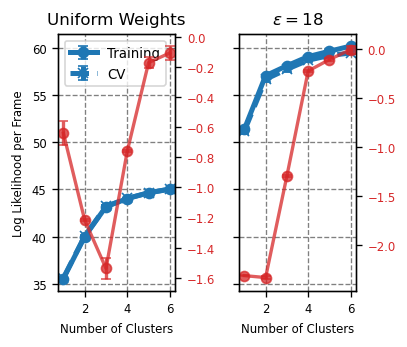

In [7]:
# shapeGMMTorch plots has a built-in plot function for this type of plot
from shapeGMMTorch import plots
# also need to load matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# create figure
fig, ax = plt.subplots(1,2,figsize=(3.5,3), dpi= 120, facecolor='w', edgecolor='k',sharex=True,sharey=True)
# Uniform Weights
ax[0].set_title("Uniform Weights",fontsize=10)
plots.plot_log_likelihood_with_dd(ax[0],cluster_array,train,cv,fontsize=7,ylabel1=True,ylabel2=False,xlabel=True, legend=True)
ax[0].legend(loc=2,fontsize=8)
# ENM Weights
ax[1].set_title("$\epsilon=18$",fontsize=10)
plots.plot_log_likelihood_with_dd(ax[1],cluster_array,eps18_train,eps18_cv,fontsize=7,ylabel1=False,ylabel2=False,xlabel=True, legend=False)
# Random Weights
#ax[2].set_title("Random Frame Weights",fontsize=12)
#plots.plot_log_likelihood_with_dd(ax[2],cluster_array,random_train,random_cv,fontsize=12,ylabel1=False,ylabel2=True,xlabel=True,legend=False)
# show plot
plt.tight_layout()
plt.savefig("beaded_helix_cluster_scan_different_eps_weights.png",dpi=300,transparent=True)
plt.show()

## scan of $\epsilon$

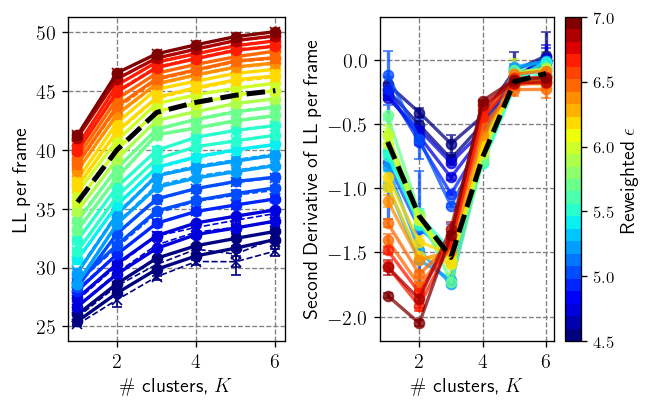

In [3]:
import matplotlib as mpl
#eps_range = np.array([5, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7,8,9,10,11,12])
#eps_str = np.array(['5', '5.1', '5.2', '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9', '6', '6.1', '6.2', '6.3', '6.4', '6.5', '6.6', '6.7', '6.8', '6.9','7','8','9','10','11','12']).astype(str)
plt.rc('text', usetex=True)
eps_range = np.array([4.5, 4.6, 4.7, 4.8, 4.9, 5, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.0, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7])
eps_str = np.array(['4.5', '4.6', '4.7', '4.8','4.9','5', '5.1', '5.2', '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9', '6.0', '6.1', '6.2', '6.3', '6.4', '6.5', '6.6', '6.7','6.8', '6.9','7']).astype(str)
cluster_array = np.arange(1,7).astype(int)
fig, ax = plt.subplots(1,2,figsize=(5.5,3.5), dpi= 120, facecolor='w', edgecolor='k')
fontsize=12
c = np.arange(np.amin(eps_range),np.amax(eps_range)+0.1,0.1)
cmap = mpl.cm.get_cmap('jet', c.size)
# Make dummie mappable
dummie_cax = ax[0].scatter(c, c, c=c, cmap=cmap)
# Clear axis
ax[0].cla()
for i, eps in enumerate(eps_str):
    train_file_name = "eps" + str(eps) + "frame_weights_ll_train_90k.dat"
    train = np.loadtxt(train_file_name)
    cv_file_name = "eps" + str(eps) + "frame_weights_ll_cv_10k.dat"
    cv = np.loadtxt(cv_file_name) 
    # Training Data
    train_mean = np.mean(train,axis=1)
    train_std = np.std(train,axis=1)
    label = "$\epsilon =$" + str(eps)
    c_bin = int((eps_range[i]-np.amin(eps_range))/0.1)
    ax[0].errorbar(cluster_array,train_mean,train_std,fmt='-o',lw=2,capsize=3,c=cmap(c_bin),label=label)
    # Validation
    valid_mean = np.mean(cv,axis=1)
    valid_std = np.std(cv,axis=1)
    ax[0].errorbar(cluster_array,valid_mean,valid_std,fmt='--x',lw=1,capsize=3,c=cmap(c_bin))
    # second derivative
    n_samples = train.shape[1]
    n_clusters = train.shape[0]
    dd = np.empty(train.shape)
    for sample in range(n_samples):
        dd[:,sample] = np.gradient(np.gradient(train[:,sample]))
    dd_mean = np.mean(dd,axis=1)
    dd_std = np.std(dd,axis=1)
    ax[1].errorbar(cluster_array,dd_mean,dd_std,fmt='-o',lw=2,capsize=3,alpha=0.75,c=cmap(c_bin))
# eps=6
eps = 6
train_file_name = "eps" + str(eps) + "frame_weights_ll_train_90k.dat"
train = np.loadtxt(train_file_name)
cv_file_name = "eps" + str(eps) + "frame_weights_ll_cv_10k.dat"
cv = np.loadtxt(cv_file_name) 
# Training Data
train_mean = np.mean(train,axis=1)
train_std = np.std(train,axis=1)
label = "$\epsilon =$" + str(eps)
c_bin = int((eps_range[i]-np.amin(eps_range))/0.1)
ax[0].errorbar(cluster_array,train_mean,train_std,fmt='--',lw=3,capsize=3,c='k',label=label)
# second derivative
n_samples = train.shape[1]
n_clusters = train.shape[0]
dd = np.empty(train.shape)
for sample in range(n_samples):
    dd[:,sample] = np.gradient(np.gradient(train[:,sample]))
dd_mean = np.mean(dd,axis=1)
dd_std = np.std(dd,axis=1)
ax[1].errorbar(cluster_array,dd_mean,dd_std,fmt='--',lw=3,capsize=3,alpha=1.0,c='k')
# plot stuff
ax[0].grid(which='major', axis='both', color='#808080', linestyle='--')
ax[0].set_ylabel("LL per frame",fontsize=fontsize)
ax[0].set_xlabel("\# clusters, $K$",fontsize=fontsize)
ax[0].tick_params(axis='both',labelsize=fontsize)
ax[1].xaxis.set_major_locator(plt.MaxNLocator(3))
ax[1].grid(which='major', axis='both', color='#808080', linestyle='--')
ax[1].set_ylabel("Second Derivative of LL per frame",fontsize=fontsize)
ax[1].set_xlabel("\# clusters, $K$",fontsize=fontsize)
ax[1].tick_params(axis='both',labelsize=fontsize)
cbar = fig.colorbar(dummie_cax, ticks=np.arange(4.5,7.5,0.5))
cbar.set_label("Reweighted $\epsilon$",fontsize=fontsize)
plt.tight_layout()
plt.savefig("beaded_helix_reweighted_eps_cluster_scans.pdf",dpi=300)
plt.show();
#plt.legend(fontsize=fontsize,loc=8)

## Similarlity measures

In [8]:
# GT
import pickle
file_obj = open("eps8_2clusters.pickle","rb")
sgmm_eps8_gt = pickle.load(file_obj)
file_obj.close()
# reweighted
import pickle
fileObj = open('beaded_helix_sgmm2_eps8_frame_weights.pickle', 'rb')
sgmm2_eps8_weights = pickle.load(fileObj)
fileObj.close()
# eps=6 three clusters
import pickle
fileObj = open('../sgmm3.obj', 'rb')
sgmm3_eps6 = pickle.load(fileObj)
fileObj.close()
# eps=6 two clusters
import pickle
fileObj = open('../sgmm2.obj', 'rb')
sgmm2_eps6 = pickle.load(fileObj)
fileObj.close()

In [12]:
from shapeGMMTorch import similarities
n=100000
s_gt = similarities.configurational_entropy(sgmm_eps8_gt,n)
s_sgmm3_eps6 = similarities.configurational_entropy(sgmm3_eps6,n)
s_sgmm2_eps6 = similarities.configurational_entropy(sgmm2_eps6,n)
s_sgmm2_eps8_weights = similarities.configurational_entropy(sgmm2_eps8_weights,n)
print(similarities.kl_divergence(sgmm3_eps6,sgmm_eps8_gt,n),similarities.kl_divergence(sgmm_eps8_gt,sgmm3_eps6,n),similarities.js_divergence(sgmm_eps8_gt,sgmm3_eps6,n),s_sgmm3_eps6[0]-s_gt[0],np.sqrt(s_sgmm3_eps6[1]**2+s_gt[1]**2))
print(similarities.kl_divergence(sgmm3_eps6,sgmm_eps8_gt,n),similarities.kl_divergence(sgmm_eps8_gt,sgmm2_eps6,n),similarities.js_divergence(sgmm_eps8_gt,sgmm2_eps6,n),s_sgmm2_eps6[0]-s_gt[0],np.sqrt(s_sgmm2_eps6[1]**2+s_gt[1]**2))
print(similarities.kl_divergence(sgmm2_eps8_weights,sgmm_eps8_gt,n),similarities.kl_divergence(sgmm_eps8_gt,sgmm2_eps8_weights,n),similarities.js_divergence(sgmm_eps8_gt,sgmm2_eps8_weights,n),s_sgmm2_eps8_weights[0]-s_gt[0],np.sqrt(s_sgmm2_eps8_weights[1]**2+s_gt[1]**2))

(28.06560636242723, 0.27923614611226666) (1.6072523781737758, 0.003970570537371689) (0.40096028825936036, 0.001812645683062119) -7.216548160687395 0.03099338438420223
(28.72729222855741, 0.28751957037551057) (1.4794806480297993, 0.0039650745119250526) (0.35773653861596444, 0.0017983806118436554) -4.022394903057176 0.01732455697578406
(0.010132197030685575, 0.0006492593614198478) (0.0313203161070561, 0.0006403262161239871) (0.007218840303372367, 0.0003231204329507715) 0.0034855791325654195 0.01732897691798313


In [14]:
eps8_weights = np.loadtxt("eps8.0_frame_weights.dat")
eps8_counts = eps8_weights/np.amin(eps8_weights)
eps8_counts = eps8_counts.astype(int)

In [15]:
print(np.sum(eps8_counts),eps8_weights.size)

5162710501 100001
